
# Semestral Work Assignment (4IZ172) – Clustering


# Imports

## Libraries

In [1]:
# pandas -> we are working with dataframes
import pandas as pd

# chardet -> used for the detection of the encoding of the csv file
import chardet

# sklearn -> the library of choice for machine learning
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# scipy
import scipy.cluster.hierarchy as sch

# re -> for regular expressions to clean text
import re

# nltk -> natural language tool kit, the library we will use for NLP
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

# inflect ->
import inflect

# matplotlib and seaborn -> for plotting
import matplotlib.pyplot as plt
import seaborn as sns



## Dataset
For this coursework i chose the FR aerospace dataset.

Not all datasets to choose from for this coursework are encoded the same, so let's look at this one in particular.

In [2]:
path = "data/FR-aerospace-translate.csv"
with open(path, 'rb') as f:
    rawdata = f.read()
result = chardet.detect(rawdata)
encoding = result['encoding']
print(f"Detected encoding: {encoding}")

Detected encoding: utf-8


By having a quick look at the file, we see it is a normal utf-8 csv, let's load it!

In [3]:

# We have the encoding, now we can read the CSV file
df_aero = pd.read_csv("data/FR-aerospace-translate.csv",encoding=encoding)
df_aero

,Name,URL,FR,EN
0,ACPI SARL,https://acpi.tech,"Société d’ingénierie fondée en 1994, nous somm...","Established in 1994, we specialize in the foll..."
1,ACRI-ST,https://www.acri-st.fr/fr/,Le siege d’ACRI-ST (créée en 1989) est situé a...,ACRI-ST's head office (created in 1989) is loc...
2,AD INDUSTRIES HYDRAULICS,https://adgroupe.com/,Filiale du Groupe AD Industrie (CA 190 M - 1 5...,Subsidiary of the AD Industry Group (CA 190 M ...
3,AD-WAIBE,https://ad-waibe.fr,Savoir-faire : - Expertise Design Thinking et ...,Know how : - Design Thinking and innovation ex...
4,ADAGOS,https://adagos.com,ADAGOS a développé une nouvelle approche neuro...,To address the challenges in the implementatio...
...,...,...,...,...
600,AES,https://ae-services.fr,Spécialisée dans l’ingénierie d’équipements d’...,"AES, specialized in the engineering of automat..."
601,AGUILA TECHNOLOGIES,https://aguila.fr/,AGUILA est un acteur clé des technologies comm...,AGUILA Technologies is an independent high-tec...
602,AGENIUM,https://agenium.group/fr,AGENIUM accompagne les grands comptes de la Dé...,AGENIUM a key partner for major accounts of De...
603,AEVA,https://aece-group.com/en/entity/aeva/,"AEVA, groupe AECE, compte 70 collaborateurs su...","AEVA, AECE Group, has 70 employees at Fléac cl..."


### Dataset statistics

In [4]:
na_count = df_aero.isna().any(axis=1).sum()
print(na_count)
print(df_aero.shape[0]-na_count)
df_aero = df_aero.dropna()

49
556


There are 49 rows containing at least 1 NA value. If we delete those, we are left with 556 full rows.


# Preprocessing
The section should contain:

Description of preprocessing steps involved
Report on the preprocessing results


### TF-IDF matrix

In [ ]:
# Sampling to compute faster
df_aero = df_aero.dropna()
df_aero_sample = df_aero.sample(n=10, random_state=42)

documents = df_aero["EN"].tolist()
names = df_aero["Name"].tolist()
vectorizer = TfidfVectorizer(stop_words='english')

tfidf = vectorizer.fit_transform(raw_documents=documents)
tfidf_df = pd.DataFrame(tfidf.todense(), index=names, columns=vectorizer.get_feature_names_out())

similarity_matrix = cosine_similarity(tfidf)
tfidf_df # type: ignore

### PCA

In [ ]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(tfidf_df)

plt.figure(figsize=(32, 24))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c='blue', edgecolors='k', s=150, alpha=0.5)
for i, filename in enumerate(names):
    plt.annotate(filename, (reduced_data[i, 0], reduced_data[i, 1]))
plt.title("Documents visualized using PCA")
plt.show()

### t-SNE

In [ ]:
# Plot tSNE embeddings function
def plot_tsne(similarity_matrix, filenames):
    perplexity = min(10, len(filenames) - 1)  # Perplexity must be lower than the number of items
    distance_matrix = 1 - similarity_matrix
    distance_matrix[distance_matrix < 0] = 0  # We do not want to have negative values
    tsne = TSNE(n_components=2, metric="precomputed", perplexity=perplexity, init="random", random_state=42)
    embedding = tsne.fit_transform(distance_matrix)

    plt.figure(figsize=(32, 24))
    plt.scatter(embedding[:, 0], embedding[:, 1], c='blue', edgecolors='k', s=150, alpha=0.5)
    for i, filename in enumerate(filenames):
        plt.annotate(filename, (embedding[i, 0], embedding[i, 1]))
    plt.title("Documents visualized using t-SNE")
    plt.show()
    
plot_tsne(similarity_matrix, names)


# Clustering
This section should contain:

List of clustering methods considered
Estimation of the number of clusters (methods, results, discussion)
Comparison of (the results of) clustering methods on the selected dataset


## Hierarchical clustering

In [ ]:
def plot_dendrogram(dtm_df:pd.DataFrame):
    
    # Perform the first part -- hierarchical clustering
    linkage_matrix = sch.linkage(dtm_df, metric='cosine', method='average')

    # Plot the dendrogram
    plt.figure(figsize=(10, 5))
    sch.dendrogram(linkage_matrix, labels=dtm_df.index, leaf_font_size=10)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Document Index')
    plt.ylabel('Distance')
    plt.show()

plot_dendrogram(tfidf_df)


## Non-hierarchical clustering

### k-Means

In [ ]:
def plot_inertia(ks:list[int], kmeans_data):
    inertias = []
    for k in ks:
        model = KMeans(n_clusters=k)
        model.fit(X=kmeans_data)
        inertias.append(model.inertia_)
        
    plt.plot(ks, inertias, '-o')
    plt.xlabel('number of clusters, k')
    plt.ylabel('inertia')
    plt.xticks(ks)
    plt.show()

k_list = list(range(1,11))
plot_inertia(ks= k_list, kmeans_data=reduced_data)

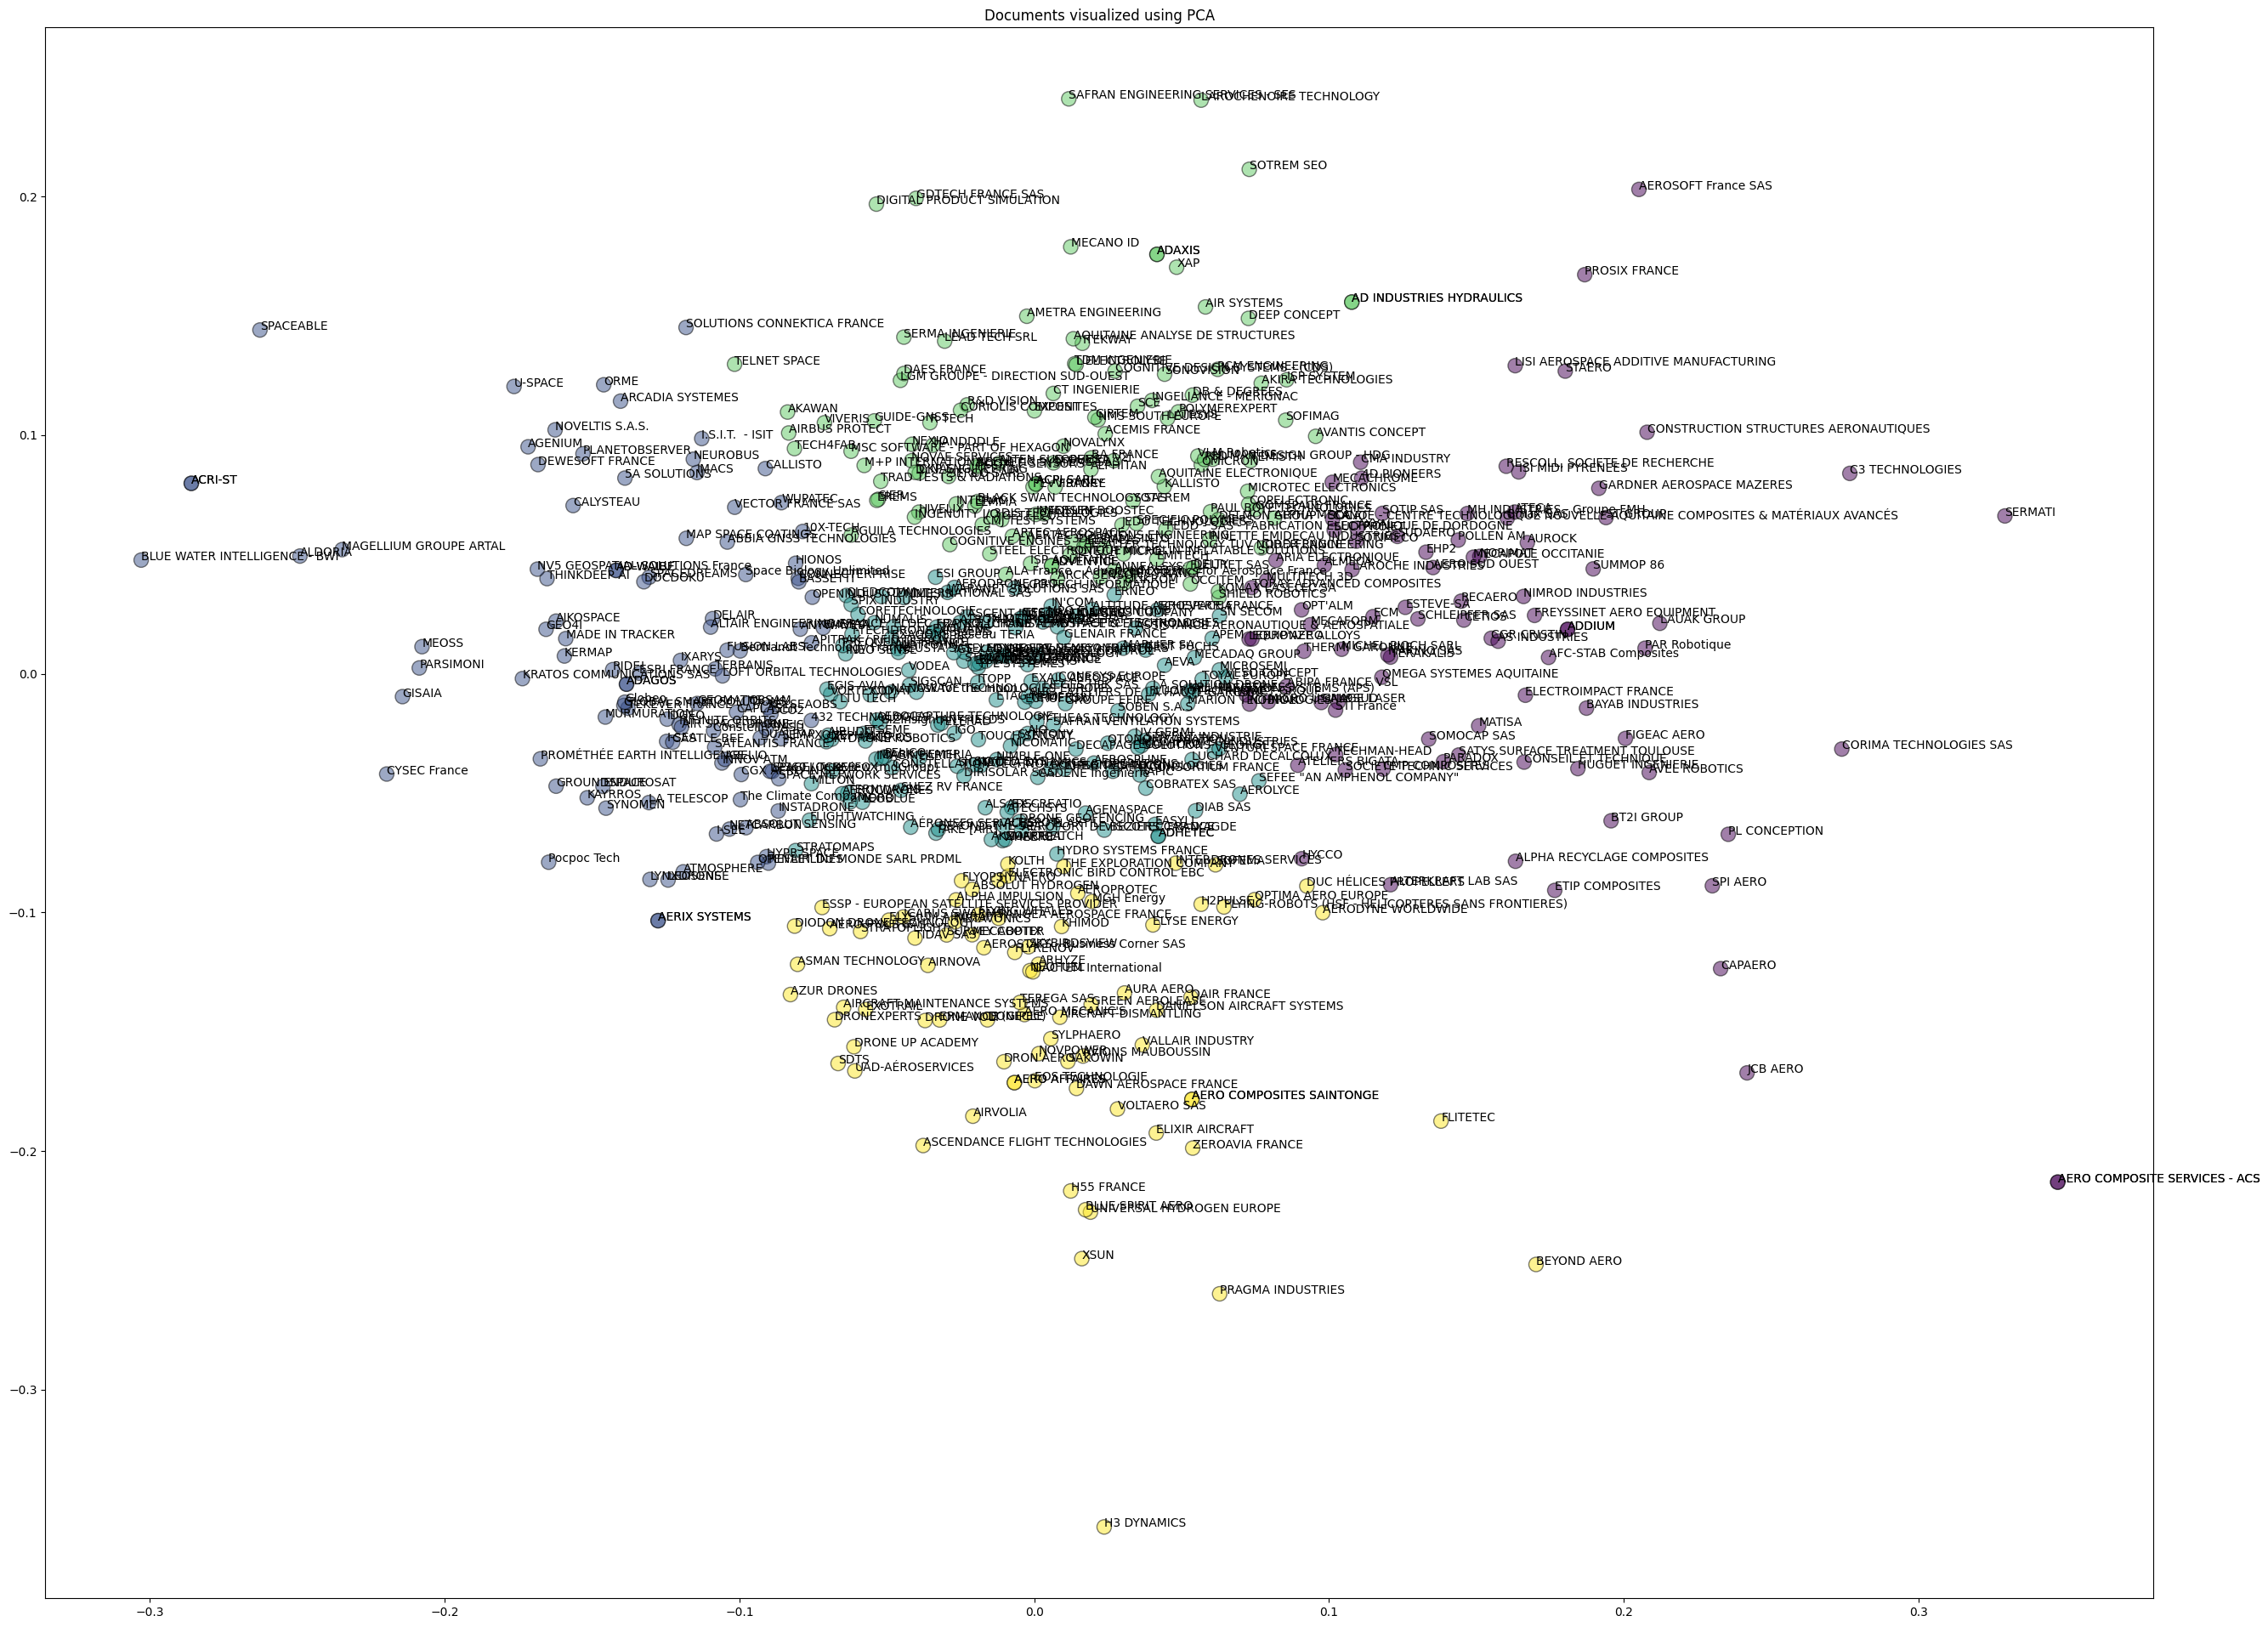

In [ ]:
kmeans = KMeans(n_clusters=5)
clusters = kmeans.fit_predict(reduced_data)

plt.figure(figsize=(32, 24))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, edgecolors='k', s=150, alpha=0.5)
for i, filename in enumerate(names):
    plt.annotate(filename, (reduced_data[i, 0], reduced_data[i, 1]))
plt.title("Documents visualized using PCA")
plt.show()


# Cluster Descriptions
The clusters (at least important part of them) should be described.

This section should contain:

Description of the selected approach
Examples of the descriptions obtained



# Visualization
This section should contain:

At least one visualization related to clustering



# Analytical Report
The entire work should be ended by the final analytical report of findings on the selected dataset. It should point out your main results, their justifications, hypotheses, conclusions, outliers, ...